````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````

# 5. Manual inversion

Now you have to use the knowledge and experience gained in the last exercise to find the lateral extent of a target, given the provided data.

### Known geology

- Water depth 2 km, 0.3 Ohm.m (you can ignore the air).
- Background resistivity is 1 Ohm.m.
- From seismic data we know that there is a potential reservoir layer at 1.5 km depth, 200 m thick.
- The target is expected to have a resistivity of over 100 Ohm.m.
- The geology is know to be a 2D structure, with no change in y-direction.

### Survey

- Two sources at $x$ = {0, 10} km; both at $y$ = 0 m, $z$ = -1950 m.
- Nine receivers at $x$ = {1, 2, 3, 4, 5, 6, 7, 8, 9} km; all at $y$ = 0 m, $z$ = -2000 m.
- Inline fields ($E_{xx}$).

# Task

1. Try to estimate the "apparent" target resistivity at each src-rec-midpoint using 1D models (`empymod`).
2. From this values, make an estimate of the lateral target extent.
3. Use this target extent to create a 3D (2D) model and calculate the responses using `emg3d`.
4. Compare the 3D responses to the data you received. Adjust the model and redo.
5. What is your final estimate of the lateral extent?

In [1]:
import emg3d
import empymod
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## How to load the data

In [3]:
# 'with' is a contextmanager, that closes the file automatically afterwards
with xr.open_dataset('./data/Data-3D.nc', engine='h5netcdf') as ds:
    # Take noise-free data, reduce data by only taking inline component
    data = ds.data.loc[:, :, b'ex', :]

## Data QC

<IPython.core.display.Javascript object>


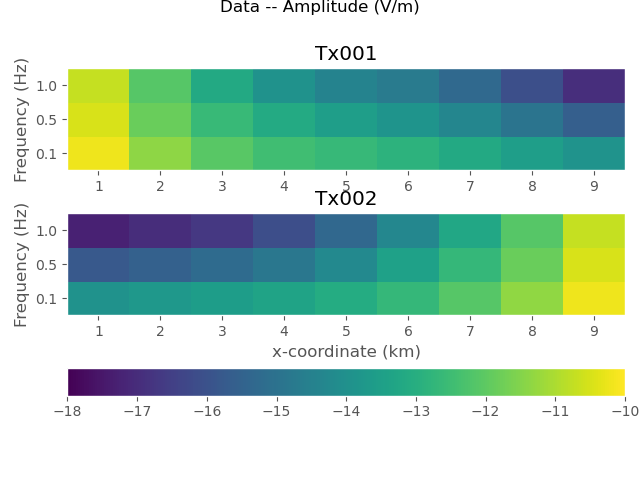

In [4]:
pseudox = np.arange(10)
pseudoy = np.r_[0, 1, 2, 3]
vmin = -18
vmax = -10

fig = plt.figure()
plt.suptitle('Data -- Amplitude (V/m)', y=1)

ax1 = plt.subplot(211)
plt.title('Tx001')
v2data = data.loc[b'Tx001', :, :].values
plt.pcolormesh(pseudox, pseudoy, np.log10(np.abs(v2data)).T, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(9)+0.5, np.arange(1, 10))
plt.yticks(np.arange(3)+0.5, np.r_[0.1, 0.5, 1.0])
plt.ylabel('Frequency (Hz)')

ax2 = plt.subplot(212)
plt.title('Tx002')
v3data = data.loc[b'Tx002', :, :].values
cf0 = plt.pcolormesh(pseudox, pseudoy, np.log10(np.abs(v3data)).T, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(9)+0.5, np.arange(1, 10))
plt.yticks(np.arange(3)+0.5, np.r_[0.1, 0.5, 1.0])
plt.xlabel('x-coordinate (km)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.colorbar(cf0, ax=[ax1, ax2], orientation='horizontal')
plt.show()

## How to use the data

The data is stored as an `xarray`, so you can do smart selections. E.g., to choose source 1, receiver 1, for the frequency of 0.5 Hz, you do:

In [5]:
data.loc[b'Tx001', b'Rx001', 0.5].values

array(1.47824926e-11-3.00799666e-11j)

The data itself knows everything about itself:

In [6]:
data.loc[b'Tx001', b'Rx001', 0.5]

<xarray.DataArray 'data' ()>
array(1.478249e-11-3.007997e-11j)
Coordinates:
    component  |S2 b'ex'
    frequency  float64 0.5
    rec_name   |S5 b'Rx001'
    recx       int64 ...
    recy       int64 ...
    recz       int64 ...
    src_name   |S5 b'Tx001'
    srcx       int64 ...
    srcy       int64 ...
    srcz       int64 ...

So to know the source x-location and the receiver x-location of this data point:

In [7]:
data.loc[b'Tx001', b'Rx001', 0.5].srcx.values, data.loc[b'Tx001', b'Rx001', 0.5].recx.values

(array(0), array(1000))

And you can also do slicing. E.g., you want all receivers for the first source at frequency 0.1 Hz:

In [8]:
data.loc[b'Tx001', :, 0.1].values

array([ 5.63872775e-11-2.54543730e-11j,  2.49259243e-12-3.74103168e-12j,
        2.34390718e-13-8.20190613e-13j,  7.12997948e-14-3.56714611e-13j,
        2.11986203e-14-2.27692547e-13j, -8.25692034e-15-1.40798481e-13j,
       -2.42465516e-14-6.34205726e-14j, -2.14453252e-14-1.95599357e-14j,
       -1.23122914e-14-2.37488582e-15j])

## Get a few parameters we are used to from the data

In [9]:
freqs = data.frequency.values  # All frequencies in the survey
xco = data.recx.values         # All receiver x-coordinates in the survey

## Plot the data

<IPython.core.display.Javascript object>


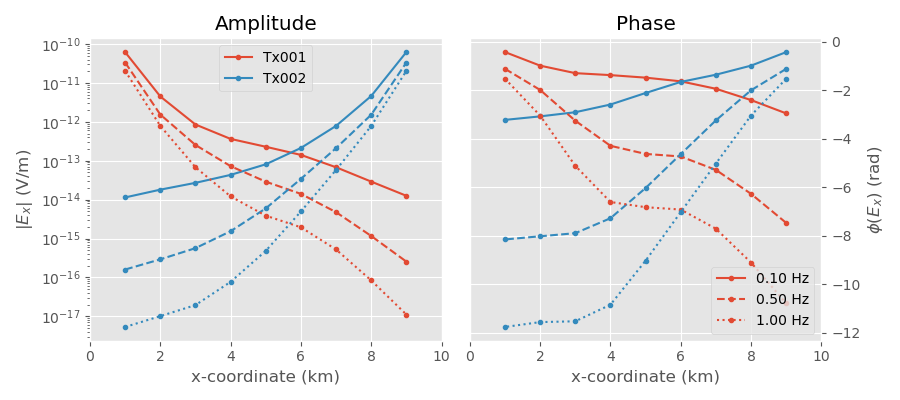

In [10]:
def pha(inp):
    return np.unwrap(np.angle(inp))
    
plt.figure(figsize=(9, 4))

ls = ['-', '--', ':']

ax1 = plt.subplot(121)
plt.title('Amplitude')
for i, f in enumerate(freqs):
    plt.plot(xco/1e3, np.abs(data.loc[b'Tx001', :, f]), 'C0.', ls=ls[i], label='Tx001' if i == 0 else '')
    plt.plot(xco/1e3, np.abs(data.loc[b'Tx002', :, f]), 'C1.', ls=ls[i], label='Tx002' if i == 0 else '')
plt.legend()
plt.xlabel('x-coordinate (km)')
plt.ylabel('$|E_x|$ (V/m)')
plt.yscale('log')
plt.xlim([0, 10])

ax2 = plt.subplot(122)
plt.title('Phase')
for i, f in enumerate(freqs):
    plt.plot(xco/1e3, pha(data.loc[b'Tx001', :, f]), 'C0.', ls=ls[i], label=f"{f:.2f} Hz")
    plt.plot(xco[::-1]/1e3, pha(data.loc[b'Tx002', ::-1, f]), 'C1.', ls=ls[i])
plt.legend()
plt.xlabel('x-coordinate (km)')
plt.ylabel('$\phi(E_x)$ (rad)')
plt.xlim([0, 10])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

# Task

Tipps:
- Start with calculating the background model with all known geological information, and compare it to the data.
- The start to look at src-rec-midpoint responses and estimate target resistivities for them.

In [11]:
empymod.Report([emg3d, xr, 'discretize'])

--------------------------------------------------------------------------------
  Date: Wed Feb 17 14:02:39 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16)
  [GCC 9.3.0]

             emg3d : 0.16.1
            xarray : 0.16.1
        discretize : 0.6.2
             numpy : 1.19.5
             scipy : 1.6.0
             numba : 0.51.2
           empymod : 2.0.3
           IPython : 7.19.0
        matplotlib : 3.3.3

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------